In [108]:
import numpy as np
import random
import matplotlib.pyplot as plt


from ipywidgets import interact, interactive, fixed, interact_manual
import zfec
import random
import scipy
import scipy.fft as fft
import timeit


%matplotlib widget


In [46]:
# globalne promenljive

fs = 44100
f0 = 10_000
df = 1_000
dt = .1
small_segment = 100

In [47]:
# Funkcije koje koristimo

def GenerateRandom(length = 1000):
    bin_string = ""
    
    for _ in range(length):
        bin_string += '1' if bool(random.getrandbits(1)) else '0'
    
    return bin_string

def GenerateSignal(bin_code : str):

    # učitavanje globalnih promenljiva
    global fs, f0, df, dt

    # pravljenje frekvencija za pakete
    f = [f0 - df // 2, f0 + df // 2]

    # priprema za pravljenje mfsk niza
    samples_per_symbol = int(int(fs) * dt)
    
    # pravljenje mfsk niza sa frekvencijama
    mfsk = []
    for bit in bin_code:
        mfsk += [f[int(bit)] for _ in range(samples_per_symbol)]
    mfsk = np.array(mfsk)
    
    # pravljenje cpmfsk signala
    delta_phi = mfsk * np.pi / (fs / 2.0)
    phi = np.cumsum(delta_phi)
    cpmfsk = np.sin(phi)

    return cpmfsk

def AddingNoise(sig, snr):

    # pravljenje šuma sa određenim SNRom
    sig_watts = np.mean(sig ** 2)
    sig_db = 10 * np.log10(sig_watts)
    noise_db = sig_db - snr
    noise_watts = 10 ** (noise_db / 10)
    noise = np.random.normal(0, np.sqrt(noise_watts), len(sig))
    
    # spajanje signala i šuma
    signal_with_noise = sig + noise

    return signal_with_noise

# def DemodulateSignal(signal, f0, f1, small_segment, fs):
    # ...

### demod, pure
def DemodulateSignal(signal, f0, f1, small_segment, sample_rate):
    bl = []
    for i in np.arange(0,len(signal)/sample_rate,dt):
        y1 = signal[int(i*sample_rate + small_segment):int((i+dt)*sample_rate) - small_segment]/1
        y1fft = scipy.fft.rfft(y1)

        n = int(dt * sample_rate)- 2 * small_segment
        freqs = fft.rfftfreq(n,1./sample_rate)

        maxf0 = 0
        maxf1 = 0

        for i in range(len(y1fft)):
            if  f0 - 300 < freqs[i] < f0 + 300 and y1fft[i] > maxf0:maxf0 = y1fft[i]
            if  f1 - 300 < freqs[i] < f1 + 300 and y1fft[i] > maxf1:maxf1 = y1fft[i]
            
        if maxf0 > maxf1: bl.append(0)
        if maxf0 < maxf1: bl.append(1)
    return bl


# def BER(input_bin, output_bin, snr):
    # ...

### BER Kalkulacija, snr nalepljen
def BER(list1, list2, snr):
    # Ensure both lists are of the same length
    min_length = min(len(list1), len(list2))
    truncated_list1 = list1[:min_length]
    truncated_list2 = list2[:min_length]
    
    # Calculate the Bit Error Rate (BER)
    errors = sum(bit1 != bit2 for bit1, bit2 in zip(truncated_list1, truncated_list2))
    ber = errors / min_length
    
    # Attach the SNR value
    result = {"BER": ber, "SNR": snr}
    
    return result

In [23]:
BERs = []
for noise in np.arange(1, -10, -1):
    for _ in range(100):
        input_bin = GenerateRandom(8 * 100) # generisanje poruke
        signal = AddingNoise(GenerateSignal(input_bin), noise) # modulacija signala
        
        output_bin = DemodulateSignal(signal, f0 - df // 2, f0 + df // 2, small_segment, fs) # demodulacija
        ber_snr = BER(list(map(int,input_bin)), output_bin, noise) # računanje BER/SNR
        BERs.append(ber_snr)
print(BERs)
# plotovanje
# fig, ax = plt.subplots(1, 1, figsize = (8, 2))
# ax.plot(BERs)

[{'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 'SNR': np.int64(1)}, {'BER': 0.0, 

In [26]:
ber_save = BERs

In [175]:
array = np.array([[item['BER'], item['SNR']] for item in BERs])
print("Test parameters, 100 random bytes transmitted 100 times, for each SNR")
sn_ber = []
for snr_i in np.unique(array[:,1]):
    avg, = np.where(array[:,1] == snr_i) ## ovo vraca singleton iz nekog razloga
    ar = array[(avg,0)]
    # print(np.average(ar))
    print(f"SNR {snr_i}db, average BER over {len(ar)} samples :{np.average(ar)}")
    sn_ber.append((snr_i, np.average(ar)))

Test parameters, 100 random bytes transmitted 100 times, for each SNR
SNR -9.0db, average BER over 100 samples :0.14045
SNR -8.0db, average BER over 100 samples :0.1213
SNR -7.0db, average BER over 100 samples :0.09371249999999998
SNR -6.0db, average BER over 100 samples :0.06747500000000001
SNR -5.0db, average BER over 100 samples :0.04575
SNR -4.0db, average BER over 100 samples :0.0264125
SNR -3.0db, average BER over 100 samples :0.012624999999999997
SNR -2.0db, average BER over 100 samples :0.0047125
SNR -1.0db, average BER over 100 samples :0.0012
SNR 0.0db, average BER over 100 samples :0.000225
SNR 1.0db, average BER over 100 samples :0.0


In [176]:
print(zip(sn_ber))

Text(0.5, 0, 'SNR[db]')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


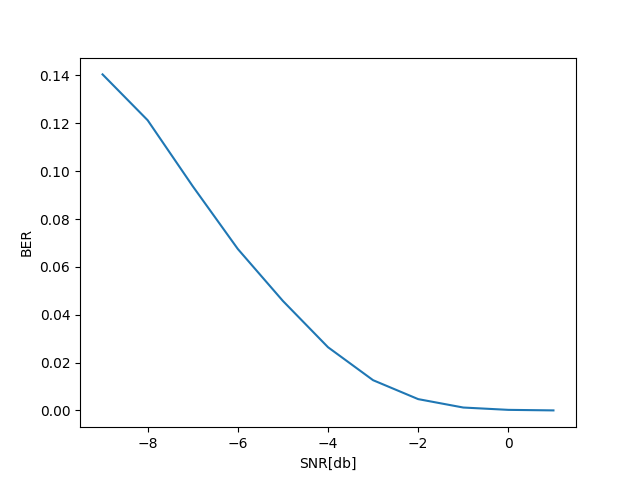

In [178]:
plt.close()
plt.clf()
plt.plot(*zip(*sn_ber))
plt.ylabel("BER")
plt.xlabel("SNR[db]")

In [89]:
print(sum(array[:,1] == -9))

100


### single shot tests for correcting errors

In [70]:
### single shot proba
print(timeit.timeit('input_bin = GenerateRandom(8 * 100)',number=100)) # generisanje poruke
# print(list(map(int,input_bin)))
signal = AddingNoise(GenerateSignal(input_bin), 1) # modulacija signala
# plt.plot(signal)
# output_bin = DemodulateSignal(signal, f0 - df // 2, f0 + df // 2, small_segment, fs) # demodulacija
# print(output_bin)
# ber_snr = BER(list(map(int,input_bin)), output_bin, noise) # računanje BER/SNR
# print(ber_snr)


NameError: name 'GenerateRandom' is not defined

### speed tests cause this is really slow

In [107]:
# timeit.timeit("GenerateRandom(8000)",number=10000,globals=globals()) # generisanje poruke
timeit.timeit("signal = AddingNoise(GenerateSignal(input_bin), 1) # modulacija signala",number=10,globals=globals()) # generisanje poruke



5.6762300730042625